In [123]:
import numpy as np
import cvxpy as cp
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt

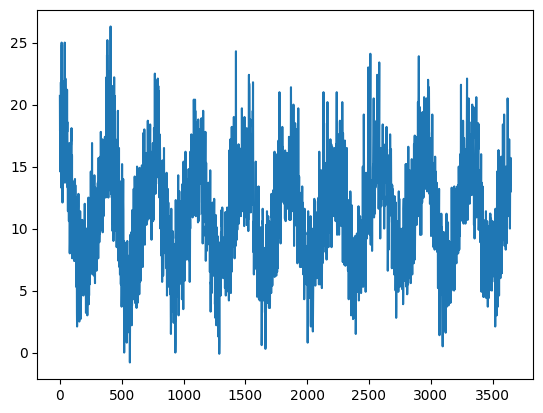

In [134]:
#Load text file and convert to pandas dataframe
data = pd.DataFrame(np.loadtxt('../data/temperature.txt'))
data = np.array(data).reshape(-1)
plt.plot(data)

### RMS error with mean as prediction

In [135]:
#Print mean of data
print(f"Mean: {np.mean(data)}")

#Print RMS of data
RMS = np.sqrt(np.mean((data - np.mean(data))**2))
print(f"RMS: {RMS}")

Mean: 11.175109649122806
RMS: 4.072984781684891


### Fit a model for the cyclic component

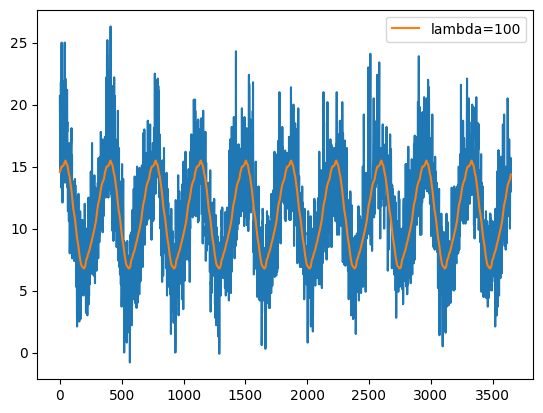

In [136]:
def fit_cyclic(data, period=365, lam=1):
    m = data.shape[0]
    
    ones = np.ones(m)
    L = sp.sparse.spdiags([-ones, ones], np.array([0, 1]), m-1, m).toarray()

    s = cp.Variable(m)

    #Define objective function
    obj1 = cp.sum_squares(s - data)
    obj2 = cp.sum_squares(L @ s)
    obj = obj1 + lam * obj2

    constraints = []
    for i in range(period, m):
        constraints.append(s[i] == s[i-period])

    #Define problem
    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()
    
    return s.value

#Plot data and s
s = fit_cyclic(data, lam=100)
plt.plot(data)
plt.plot(s,label='lambda=100')
plt.legend()
plt.show()

### Residual after fitting the cyclic component

RMS: 2.7328242649509975


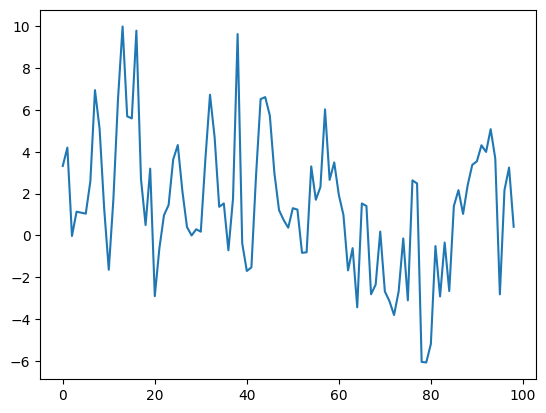

In [149]:
residual = np.array(data - s)
residual = residual.reshape(-1)
plt.plot(residual[1:100])

RMS = np.sqrt(np.mean((data - s)**2))
print(f"RMS: {RMS}")

### Fit an AR model for the residual

In [138]:
ar = 5
theta = cp.Variable(ar)
m = residual.shape[0]
obj = cp.sum([cp.square(residual[i] -  theta @ residual[i-5:i]) for i in range(5, m)])
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
print(f"prob status: {prob.status}")

prob status: optimal


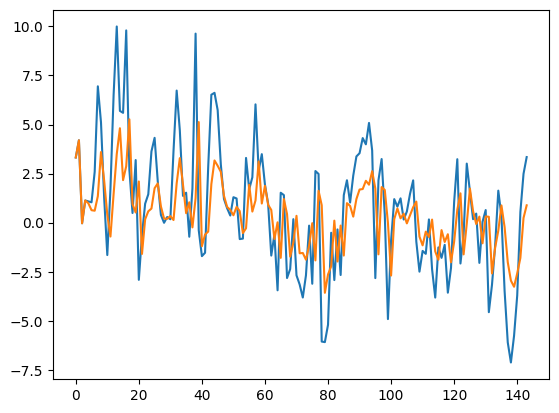

In [150]:
trend_pred = [theta.value @ residual[i-5:i] for i in range(5, m)]
trend = residual.copy()
trend[ar:] = trend_pred

plt.plot(residual[1:145])
plt.plot(trend[1:145])


### Final model with RMS

RMS: 2.348262925339221


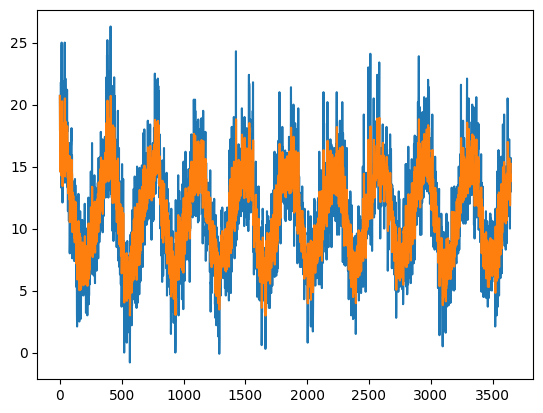

In [151]:
total_estimate = s + trend
RMS = np.sqrt(np.mean((data - total_estimate)**2))
print(f"RMS: {RMS}")

plt.plot(data)
plt.plot(total_estimate)